(triangle)=
# Triangle

## Introduction

With this User Guide, we will be covering all of the core functionality of `chainladder`.
All important user functionality can be referenced from the top level of the library and
so importing the library as the `cl` namespace is the preferred way of importing from `chainladder`.

In [2]:
import chainladder as cl

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%config InlineBackend.figure_format = 'retina'

```{epigraph}
Analysis is the intersection of data, models, and assumptions.
```

Reserving analysis is no different and the loss Triangle is the most ubiquitous data construct used by actuaries today.  The chainladder package has its own :class:`Triangle` data structure that behaves much like a pandas ``DataFrame``.  

### Why not Pandas?
This begs the question, why not just use pandas?
There are several advantages over having a dedicated Triangle object:

  * Actuaries work with sets of triangles.  DataFrames, being two dimensional, support single triangles with grace but become unwieldy with multiple triangles.
  * We can carry through the meaningful pandas functionality while also supporting triangle specific methods not found in pandas
  * Improved memory footprint with sparse array representation in backend
  * Calculated fields with "virtual" columns allows for lazy column evaluation of Triangles as well as improved memory footprint for larger triangles.
  * Ability to support GPU-based backends.

Ultimately, there are a lot of things pandas can do that are not relevant to reserving, and there are a lot of things a Triangle needs to do that are not handled easily with pandas.

### Structure

The :class:`Triangle` is the data structure of the chainladder package. Just as
Scikit-learn likes to only consume numpy arrays, Chainladder only likes
Triangles.  It is a 4D data structure with labeled axes.  These axes are its
index, columns, origin, development.

``index`` (axis 0):
    The index  is the lowest grain at which you want to manage the triangle.
    These can be things like state or company.  Like a ``pandas.multiIndex``, you
    can throw more than one column into the index.

``columns`` (axis 1):
    Columns are where you would want to store the different numeric values of your
    data. Paid, Incurred, Counts are all reasonable choices for the columns of your
    triangle.

``origin`` (axis 2):
    The origin is the period of time from which your columns originate.  It can
    be an Accident Month, Report Year, Policy Quarter or any other period-like vector.

``development`` (axis 3):
    Development represents the development age or date of your triangle.
    Valuation Month, Valuation Year, Valuation Quarter are good choices.

Despite this structure, you interact with it in the style of pandas. You would
use ``index`` and ``columns`` in the same way you would for a pandas DataFrame.
You can think of the 4D structure as a pandas DataFrame where each cell (row,
column) is its own triangle.

```{eval-rst}
.. image:: ../images/triangle_graphic.PNG
```

Like pandas, you can access the ``values`` property of a triangle to get its numpy
representation, however the Triangle class provides many helper methods to
keep the shape of the numpy representation in sync with the other Triangle
properties.

## Creating a Triangle

### Basic requirements
You must have a pandas DataFrame on hand to create a triangle.  While
data can come in a variety of forms those formats should be coerced to a pandas
DataFrame before creating a triangle. The DataFrame also **must** be in tabular
(long) format, not triangle (wide) format:

```{eval-rst}
.. image:: ../images/triangle_bad_good.PNG
```

At a minimum, the DataFrame must also:

  1. have "date-like" columns for the ``origin`` and ``development`` period of the triangle.
  2. Have a numeric column(s) representing the amount(s) of the triangle.

The reason for these restriction is that the :class:`Triangle` infers a lot of
useful properties from your DataFrame.  For example, it will determine the ``grain``
and ``valuation_date`` of your triangle which in turn are used to derive many
other properties of your triangle without further prompting from you.

### Date Inference

When instantiating a :class:`Triangle`, the ``origin`` and ``development``
arguments can take a ``str`` representing the column name in your pandas DataFrame
that contains the relevant information.  Alternatively, the arguments can also
take a ``list`` in the case where your DataFrame includes multiple columns that
represent the dimension, e.g. ``['accident_year','accident_quarter']`` can be
supplied to create an ``origin`` dimension at the accident quarter grain.



```python
cl.Triangle(data, origin='Acc Year', development=['Cal Year', 'Cal Month'], columns=['Paid Loss'])
```
 The :class:`Triangle` relies heavily on pandas date inference. In fact,
 ``pd.to_datetime(date_like)`` is exactly how it works.  While pandas is excellent
 at inference, it is not perfect. When initializing a Triangle you can always
 use the ``origin_format`` and/or ``development_format`` arguments to force
 the inference.  For example, ``origin_format='%Y/%m/%d'``

### Multidimensional Triangle
So far we've seen how to create a single Triangle, but as described in the Intro
the Triangle class can hold multiple triangles at once.  These triangles share the
same ``origin`` and ``development`` axes and act as individual cells would in a
pandas DataFrame.  By specifying one or more ``column`` and one or more ``index``,
we can fill out the 4D triangle structure.

```python
cl.Triangle(data, origin='Acc Year', development='Cal Year',
            columns=['Paid Loss', 'Incurred Loss'],
            index=['Line of Business', 'State'])
```

### Sample Data

The ``chainladder`` package has several sample triangles.  Many of these come
from existing papers and can be used to verify the results of those papers.
Additionally, They are a quick way of exploring the functionality of the package.
These triangles can be called by name using the :func:`~chainladder.load_sample` function.

In [2]:
cl.load_sample('clrd')

,Triangle Summary
Valuation:,1997-12
Grain:,OYDY
Shape:,"(775, 6, 10, 10)"
Index:,"[GRNAME, LOB]"
Columns:,"[IncurLoss, CumPaidLoss, BulkLoss, EarnedPremDIR, EarnedPremCeded, EarnedPremNet]"


### Other Parameters

Whether a triangle is cumulative or incremental in nature cannot be inferred
from the "date-like" vectors of your DataFrame.  You can optionally specify this
property with the ``cumulative`` parameter.
```python
cl.Triangle(
    data, origin='Acc Year', development=['Cal Year'], 
    columns=['PaidLoss'], cumulative=True)
```

```{note}
The ``cumulative`` parameter is completely optional.  If it is not specified,
the Triangle will infer its cumulative/incremental status at the point you
call on the `cum_to_incr` or `incr_to_cum` methods discussed below.  Some methods
may not work until the cumulative/incremental status is known.
```

**Backends**

`Triangle` is built on numpy which serves as the array backend by default.
However, you can now swap array_backend between numpy, cupy, and sparse to switch
between CPU and GPU-based computations or dense and sparse backends.

Array backends can be set globally:


In [3]:
cl.options.set_option('array_backend', 'cupy')
cl.options.reset_option()

Alternatively, they can be set per Triangle instance.

```python
cl.Triangle(..., array_backend='cupy')
```

```{note}
You must have a CUDA-enabled graphics card and CuPY installed to use the GPU
backend.  These are optional dependencies of chainladder.
```

Chainladder by default will swap between the ``numpy`` and ``sparse`` backends.  This
substantially improves the memory footprint of chainladder substantially beyond
what can be achieved with pandas alone.  When a Triangle becomes sufficiently large
and has a lot of 0 or null entries, the triangle will silently swap between the
``numpy`` and ``sparse`` backends.

In [4]:
prism = cl.load_sample('prism')
prism

,Triangle Summary
Valuation:,2017-12
Grain:,OMDM
Shape:,"(34244, 4, 120, 120)"
Index:,"[ClaimNo, Line, Type, ClaimLiability, Limit, Deductible]"
Columns:,"[reportedCount, closedPaidCount, Paid, Incurred]"


In [5]:
prism.array_backend

'sparse'

In [6]:
prism.sum().array_backend

'numpy'

You can globally disable the backend swapping by invoking ``auto_sparse(False)``.
Any triangle with a cupy backend will not invoke auto_sparse.  In the future it may be supported
when there is better sparse-GPU array support.:

In [7]:
cl.options.set_option('auto_sparse', False)
prism = cl.load_sample('prism', array_backend='sparse')
prism.array_backend

'sparse'

In [8]:
prism.sum().array_backend

'numpy'

```{warning}
Loading 'prism' with the numpy backend will consume all of your systems memory.
```

## Basic Functionality

### Representation

The `Triangle` has two different representations.  When only a single
``index`` AND single ``column`` is selected.  The triangle is the typical 2-dimensional
representation we typically think of.

In [9]:
triangle = cl.load_sample('ukmotor')
print(triangle.shape)
triangle

(1, 1, 7, 7)


,12,24,36,48,60,72,84
2007,"3,511","6,726","8,992","10,704","11,763","12,350","12,690"
2008,"4,001","7,703","9,981","11,161","12,117","12,746",
2009,"4,355","8,287","10,233","11,755","12,993",,
2010,"4,295","7,750","9,773","11,093",,,
2011,"4,150","7,897","10,217",,,,
2012,"5,102","9,650",,,,,
2013,"6,283",,,,,,


If more than one ``index`` or more than one column is present, then the Triangle
takes on more of a summary view.

In [10]:
triangle = cl.load_sample('CLRD')
print(triangle.shape)
triangle

(775, 6, 10, 10)


,Triangle Summary
Valuation:,1997-12
Grain:,OYDY
Shape:,"(775, 6, 10, 10)"
Index:,"[GRNAME, LOB]"
Columns:,"[IncurLoss, CumPaidLoss, BulkLoss, EarnedPremDIR, EarnedPremCeded, EarnedPremNet]"


### Valuation vs Development

While most Estimators that use triangles expect the development period to be
expressed as an origin age, it is possible to transform a triangle into a valuation
triangle where the development periods are converted to valuation periods.  Expressing
triangles this way may provide a more convenient view of valuation slices.
Switching between a development triangle and a valuation triangle can be
accomplished with the method `dev_to_val` and its inverse `val_to_dev`.

In [11]:
cl.load_sample('raa').dev_to_val()

,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990
1981,"5,012","8,269","10,907","11,805","13,539","16,181","18,009","18,608","18,662","18,834"
1982,,106,"4,285","5,396","10,666","13,782","15,599","15,496","16,169","16,704"
1983,,,"3,410","8,992","13,873","16,141","18,735","22,214","22,863","23,466"
1984,,,,"5,655","11,555","15,766","21,266","23,425","26,083","27,067"
1985,,,,,"1,092","9,565","15,836","22,169","25,955","26,180"
1986,,,,,,"1,513","6,445","11,702","12,935","15,852"
1987,,,,,,,557,"4,020","10,946","12,314"
1988,,,,,,,,"1,351","6,947","13,112"
1989,,,,,,,,,"3,133","5,395"
1990,,,,,,,,,,"2,063"


Triangles have the ``is_val_tri`` property that denotes whether a triangle is in valuation
mode. The latest diagonal of a Triangle is a valuation triangle.


In [12]:
cl.load_sample('raa').latest_diagonal.is_val_tri

True

### Incremental vs Cumulative

A triangle is either cumulative or incremental.  The ``is_cumulative``
property will identify this trait.  Accumulating an incremental triangle can
be acomplished with `incr_to_cum`.  The inverse operation is `cum_to_incr`.


In [13]:
raa = cl.load_sample('raa')
print(raa.is_cumulative)
raa.cum_to_incr()

True


,12,24,36,48,60,72,84,96,108,120
1981,"5,012","3,257","2,638",898,"1,734","2,642","1,828",599,54,172
1982,106,"4,179","1,111","5,270","3,116","1,817",-103,673,535,
1983,"3,410","5,582","4,881","2,268","2,594","3,479",649,603,,
1984,"5,655","5,900","4,211","5,500","2,159","2,658",984,,,
1985,"1,092","8,473","6,271","6,333","3,786",225,,,,
1986,"1,513","4,932","5,257","1,233","2,917",,,,,
1987,557,"3,463","6,926","1,368",,,,,,
1988,"1,351","5,596","6,165",,,,,,,
1989,"3,133","2,262",,,,,,,,
1990,"2,063",,,,,,,,,


### Triangle Grain

If your triangle has origin and development grains that are more frequent then
yearly, you can easily swap to a higher grain using the `grain` method of the
`Triangle`. The `grain` method recognizes Yearly (Y), Quarterly (Q), and
Monthly (M) grains for both the origin period and development period.

In [14]:
cl.load_sample('quarterly')

,Triangle Summary
Valuation:,2006-03
Grain:,OYDQ
Shape:,"(1, 2, 12, 45)"
Index:,[Total]
Columns:,"[incurred, paid]"


In [15]:
cl.load_sample('quarterly').grain('OYDY')

,Triangle Summary
Valuation:,2006-03
Grain:,OYDY
Shape:,"(1, 2, 12, 12)"
Index:,[Total]
Columns:,"[incurred, paid]"


It is generally a good practice to bring your data in at the lowest grain available,
so that you have full flexibility in aggregating to the grain of your choosing for
analysis and separately, the grain of your choosing for reporting and communication.

### Link Ratios

The age-to-age factors or link ratios of a Triangle can be accessed with the
``link_ratio`` property.  Triangles also have a `heatmap` method that can optionally
be called to apply conditional formatting to triangle values along an axis.  The
heatmap method requires IPython/Jupyter notebook to render.


In [16]:
triangle = cl.load_sample('abc')
triangle.link_ratio.heatmap()

,12-24,24-36,36-48,48-60,60-72,72-84,84-96,96-108,108-120,120-132
1977,2.2263,1.3933,1.1835,1.1070,1.0679,1.0468,1.0304,1.0231,1.0196,1.0163
1978,2.2682,1.3924,1.1857,1.1069,1.0649,1.0451,1.0301,1.0267,1.0207,
1979,2.2331,1.4014,1.1871,1.1068,1.0649,1.0418,1.0352,1.0276,,
1980,2.1988,1.3944,1.2021,1.1014,1.0702,1.0496,1.0394,,,
1981,2.2115,1.4004,1.1764,1.1094,1.0706,1.0536,,,,
1982,2.2290,1.3872,1.2037,1.1264,1.0956,,,,,
1983,2.2918,1.4296,1.2197,1.1337,,,,,,
1984,2.3731,1.4654,1.2283,,,,,,,
1985,2.4457,1.4704,,,,,,,,
1986,2.4031,,,,,,,,,


The Triangle ``link_ratio`` property has unique properties from regular triangles.
They are considered patterns.


In [17]:
triangle.link_ratio.is_pattern

True

They are considered incremental, and accumulate in a multiplicative fashion.


In [18]:
triangle = cl.load_sample('abc')
triangle.link_ratio.incr_to_cum()

,12-Ult,24-Ult,36-Ult,48-Ult,60-Ult,72-Ult,84-Ult,96-Ult,108-Ult,120-Ult
1977,4.9633,2.2293,1.6000,1.3519,1.2213,1.1436,1.0924,1.0601,1.0362,1.0163
1978,4.9795,2.1954,1.5767,1.3298,1.2014,1.1282,1.0795,1.0479,1.0207,
1979,4.8528,2.1731,1.5507,1.3063,1.1802,1.1083,1.0638,1.0276,,
1980,4.7394,2.1555,1.5458,1.2859,1.1675,1.0910,1.0394,,,
1981,4.5594,2.0616,1.4722,1.2514,1.1280,1.0536,,,,
1982,4.5932,2.0607,1.4855,1.2341,1.0956,,,,,
1983,4.5302,1.9767,1.3827,1.1337,,,,,,
1984,4.2715,1.8000,1.2283,,,,,,,
1985,3.5962,1.4704,,,,,,,,
1986,2.4031,,,,,,,,,


### Commutativity

Where possible, the triangle methods are designed to be commutative.  For example,
each of these operations is functionally equivalent.

In [19]:
tri = cl.load_sample('quarterly')
# Functionally equivalent transformations
tri.grain('OYDY').val_to_dev() == tri.val_to_dev().grain('OYDY')
tri.cum_to_incr().grain('OYDY').val_to_dev() == tri.val_to_dev().cum_to_incr().grain('OYDY')
tri.grain('OYDY').cum_to_incr().val_to_dev().incr_to_cum() == tri.val_to_dev().grain('OYDY')

True

### Performance Tips

Being mindful of commutativity and computational intensity can really help improve
the performance of the package, particularly for really large triangles.  Consider
these examples that produce identical outputs but with drastically different
performance. In general, aggregations reduce the number of cells in a Triangle
and should come as early in your method chain as possible.


In [20]:
import timeit
prism = cl.load_sample('prism')
# Accumulation before aggregation - BAD
timeit.timeit(lambda : prism.incr_to_cum().sum(), number=1)

25.725541299999996

In [21]:
# Aggregation before accumulation - GOOD
timeit.timeit(lambda : prism.sum().incr_to_cum(), number=1)

0.05498839999999916

In other cases, querying the Triangle in clever ways can improve performance.
Consider that the ``latest_diagonal`` of a cumulative Triangle is equal to the
sum of its incremental values along the 'development' axis.

In [22]:
# Accumulating a large triangle to get latest_diagonal - BAD
timeit.timeit(lambda : prism.incr_to_cum().latest_diagonal, number=1)

19.788624399999996

In [23]:
# Summing incrementals of a large triangle to get latest_diagonal - GOOD
timeit.timeit(lambda : prism.sum('development'), number=1)

0.07332869999999758

### Trend
A uniform `trend` factor can also be applied to a Triangle.  The trend can
be applied along the ``origin`` or ``valuation`` axes.

In [24]:
tri = cl.load_sample('ukmotor')
# Dividing by original triangle to show the trend factor
tri.trend(0.05, axis='valuation')/tri

,12,24,36,48,60,72,84
2007,1.3401,1.2763,1.2155,1.1576,1.1025,1.0500,1.0000
2008,1.2763,1.2155,1.1576,1.1025,1.0500,1.0000,
2009,1.2155,1.1576,1.1025,1.0500,1.0000,,
2010,1.1576,1.1025,1.0500,1.0000,,,
2011,1.1025,1.0500,1.0000,,,,
2012,1.0500,1.0000,,,,,
2013,1.0000,,,,,,


While the `trend` method only allows for a single trend, you can create
compound trends using ``start`` and ``end`` arguments and chaining them together.

In [25]:
tri.trend(0.05, axis='valuation', start=tri.valuation_date, end='2011-12-31') \
   .trend(0.10, axis='valuation', start='2011-12-31')/tri

,12,24,36,48,60,72,84
2007,1.6142,1.4674,1.3340,1.2128,1.1025,1.0500,1.0000
2008,1.4674,1.3340,1.2128,1.1025,1.0500,1.0000,
2009,1.3340,1.2127,1.1025,1.0500,1.0000,,
2010,1.2128,1.1025,1.0500,1.0000,,,
2011,1.1025,1.0500,1.0000,,,,
2012,1.0500,1.0000,,,,,
2013,1.0000,,,,,,


### Correlation Tests

The multiplicative chainladder method is based on the strong assumptions of
independence across origin years and across valuation years. Mack developed
tests to verify if these assumptions hold.

These tests are included as methods on the triangle class `valuation_correlation`
and `development_correlation`. ``False`` indicates that correlation between years
is not sufficiently large.

In [26]:
triangle = cl.load_sample('raa')
triangle.valuation_correlation().z_critical

,1982,1983,1984,1985,1986,1987,1988,1989,1990
1981,False,False,False,False,False,False,False,False,False


triangle.development_correlation().t_critical

There are many properties of these correlation tests and they've been included
as their own classes.  Refer to `ValuationCorrelation` and
`DevelopmentCorrelation` for additional information.

{cite}`mack1994`

## Pandas-style syntax

We've chosen to keep as close as possible to pandas syntax for Triangle data
manipulation.  Relying on the most widely used data manipulation library in Python
gives us two benefits.  This not only allows for easier adoption, but also provides
stability to the ``chainladder`` API.


### Slicing and Filtering

With a newly minted `Triangle`, individual triangles can be sliced out
of the object using pandas-style ``loc``/``iloc`` or boolean filtering.

In [28]:
clrd = cl.load_sample('clrd')
clrd.iloc[0,1]
clrd[clrd['LOB']=='othliab']
clrd['EarnedPremDIR']

,Triangle Summary
Valuation:,1997-12
Grain:,OYDY
Shape:,"(775, 1, 10, 10)"
Index:,"[GRNAME, LOB]"
Columns:,[EarnedPremDIR]


```{note}
Boolean filtering on non-index columns in pandas feels natural.  We've exposed
the same syntax specifically for the index column(s) of the Triangle without the
need for ``reset_index()`` or trying to boolean-filter a ``MultiIndex``. This is
a divergence from the pandas API.
```

As of version ``0.7.6``, four-dimensional slicing is supported:

In [29]:
clrd = cl.load_sample('clrd')
clrd.iloc[[0, 10, 3], 1:8, :5, :]
clrd.loc[:'Aegis Grp', 'CumPaidLoss':, '1990':'1994', :48]

,Triangle Summary
Valuation:,1997-12
Grain:,OYDY
Shape:,"(5, 5, 5, 4)"
Index:,"[GRNAME, LOB]"
Columns:,"[CumPaidLoss, BulkLoss, EarnedPremDIR, EarnedPremCeded, EarnedPremNet]"


As of version ``0.8.3``, ``.iat`` and ``at`` functionality have been added.  Similar
to pandas, one can use these for value assignment for a single cell of a `Triangle`.
When a 'sparse' backend is in use, these accessors are the only way to modify individual
cells of a triangle.


In [30]:
raa = cl.load_sample('raa').set_backend('sparse')
# To modify a sparse triangle, we need to use at or iat
raa.at['Total', 'values', '1985', 12] = 10000

### Arithmetic

Most arithmetic operations can be used to create new triangles within your
triangle instance. Like with pandas, these can automatically be added as new
columns to your `Triangle`.

In [31]:
clrd = cl.load_sample('clrd')
clrd['CaseIncur'] = clrd['IncurLoss']-clrd['BulkLoss']
clrd

,Triangle Summary
Valuation:,1997-12
Grain:,OYDY
Shape:,"(775, 7, 10, 10)"
Index:,"[GRNAME, LOB]"
Columns:,"[IncurLoss, CumPaidLoss, BulkLoss, EarnedPremDIR, EarnedPremCeded, EarnedPremNet, CaseIncur]"


For `origin` and `development` axes, arithmetic follows `numpy broadcasting <https://numpy.org/doc/1.18/user/theory.broadcasting.html#array-broadcasting-in-numpy>`_
rules.  If broadcasting fails, arithmetic operations will rely on ``origin`` and
``development`` vectors to determine whether an operation is legal.


In [32]:
raa = cl.load_sample('raa')
# Allow for arithmetic beyond numpy broadcasting rules
raa[raa.origin<'1985']+raa[raa.origin>='1985']

,12,24,36,48,60,72,84,96,108,120
1981,"5,012","8,269","10,907","11,805","13,539","16,181","18,009","18,608","18,662","18,834"
1982,106,"4,285","5,396","10,666","13,782","15,599","15,496","16,169","16,704",
1983,"3,410","8,992","13,873","16,141","18,735","22,214","22,863","23,466",,
1984,"5,655","11,555","15,766","21,266","23,425","26,083","27,067",,,
1985,"1,092","9,565","15,836","22,169","25,955","26,180",,,,
1986,"1,513","6,445","11,702","12,935","15,852",,,,,
1987,557,"4,020","10,946","12,314",,,,,,
1988,"1,351","6,947","13,112",,,,,,,
1989,"3,133","5,395",,,,,,,,
1990,"2,063",,,,,,,,,


```python
# Numpy broadcasting equivalent fails
raa[raa.origin<'1985'].values+raa[raa.origin>='1985'].values
```

Arithmetic between two Triangles with different labels will align the axes
of each Triangle consistent with arithmetic of a pandas Series.  Bypassing
index matching can be accomplished with arithmetic between an Triangle and an array.


In [33]:
s1 = cl.load_sample('clrd').iloc[:3]
s2 = s1.sort_index(ascending=False)
s1 + s2 == 2 * s1

True

In [34]:
s1 + s2.values == 2 * s1

False

In [35]:
s3 = s1.iloc[:, ::-1]
s1 + s3 == 2 * s1

True

### Virtual Columns
There are instances where we want to defer calculations, we can create "virtual"
columns that defer calculation to when needed.  These columns can be created by wrapping a
normal column in a function.  Lambda expressions work as a tidy representation of
virtual columns.

In [36]:
clrd = cl.load_sample('clrd')
# A physical column with immediate evaluation
clrd['PaidLossRatio'] = clrd['CumPaidLoss'] / clrd['EarnedPremDIR']
# A virtual column with deferred evaluation
clrd['PaidLossRatio'] = lambda clrd : clrd['CumPaidLoss'] / clrd['EarnedPremDIR']
# Good - Defer loss ratio calculation until after summing premiums and losses
clrd.sum()['PaidLossRatio']

,12,24,36,48,60,72,84,96,108,120
1988,0.2424,0.4783,0.5980,0.6682,0.7097,0.7327,0.7449,0.7515,0.7569,0.7591
1989,0.2517,0.4901,0.6115,0.6829,0.7240,0.7457,0.7576,0.7651,0.7687,
1990,0.2548,0.4903,0.6114,0.6806,0.7168,0.7368,0.7488,0.7547,,
1991,0.2364,0.4558,0.5673,0.6311,0.6658,0.6839,0.6938,,,
1992,0.2423,0.4601,0.5671,0.6266,0.6598,0.6765,,,,
1993,0.2463,0.4618,0.5644,0.6227,0.6538,,,,,
1994,0.2523,0.4602,0.5592,0.6159,,,,,,
1995,0.2478,0.4445,0.5363,,,,,,,
1996,0.2459,0.4280,,,,,,,,
1997,0.2383,,,,,,,,,


Virtual column expressions should only reference other columns in the same triangle.
A Triangle without all the underlying columns will fail.

```python
# Eliminating EarnedPremDIR will result in a calculation failure
clrd[['CumPaidLoss', 'PaidLossRatio']].sum()['PaidLossRatio']
```

When used in tandem with the 'sparse' backend, virtual columns can also substantially
reduce the memory footprint of your Triangle.  This is because the calculation
expression is the only thing in memory.


### Aggregations

It is generally good practice to bring your data into ``chainladder`` at a ganularity
that is comfortably supported by your system RAM.  This provides the greatest flexibility
in analyzing your data within the ``chainladder`` framework.  However, not everything
needs to be analyzed at the most granular level. Like pandas, you can aggregate
multiple triangles within a `Triangle` by using `sum()` which can
optionally be coupled with `groupby()`.


In [37]:
clrd = cl.load_sample('clrd')
clrd.sum()

,Triangle Summary
Valuation:,1997-12
Grain:,OYDY
Shape:,"(1, 6, 10, 10)"
Index:,"[GRNAME, LOB]"
Columns:,"[IncurLoss, CumPaidLoss, BulkLoss, EarnedPremDIR, EarnedPremCeded, EarnedPremNet]"


In [38]:
clrd.groupby('LOB').sum()

,Triangle Summary
Valuation:,1997-12
Grain:,OYDY
Shape:,"(6, 6, 10, 10)"
Index:,[LOB]
Columns:,"[IncurLoss, CumPaidLoss, BulkLoss, EarnedPremDIR, EarnedPremCeded, EarnedPremNet]"


By default, the aggregation will apply to the first axis with a length greater
than 1. Alternatively, you can specify the axis using the ``axis`` argument of
the aggregate method.

Like pandas, the `groupby` method supports any groupable list.  This allows for
complex groupings that can be derived dynamically.


In [39]:
clrd = cl.load_sample('clrd')
clrd = clrd[clrd['LOB']=='comauto']
# Identify the largest commercial auto carriers (by premium) for 1997
top_10 = clrd['EarnedPremDIR'].groupby('GRNAME').sum().latest_diagonal.loc[..., '1997', :].to_frame().nlargest(10)
# Group any companies together that are not in the top 10
clrd.groupby(clrd.index['GRNAME'].map(lambda x: x if x in top_10.index else 'Remainder')).sum()

,Triangle Summary
Valuation:,1997-12
Grain:,OYDY
Shape:,"(11, 6, 10, 10)"
Index:,[GRNAME]
Columns:,"[IncurLoss, CumPaidLoss, BulkLoss, EarnedPremDIR, EarnedPremCeded, EarnedPremNet]"


### Converting to DataFrame
When a triangle is presented with a single index level and single column, it
becomes a 2D object.  As such, its display format changes to that similar to a
dataframe.  These 2D triangles can easily be converted to a pandas dataframe
using the `to_frame` method.


In [40]:
clrd = cl.load_sample('clrd')
clrd[clrd['LOB']=='ppauto']['CumPaidLoss'].sum().to_frame()

,12,24,36,48,60,72,84,96,108,120
1988,3092818.0,5942711.0,7239089.0,7930109.0,8318795.0,8518201.0,8610355.0,8655509.0,8682451.0,8690036.0
1989,3556683.0,6753435.0,8219551.0,9018288.0,9441842.0,9647917.0,9753014.0,9800477.0,9823747.0,NaN
1990,4015052.0,7478257.0,9094949.0,9945288.0,10371175.0,10575467.0,10671988.0,10728411.0,NaN,NaN
1991,4065571.0,7564284.0,9161104.0,10006407.0,10419901.0,10612083.0,10713621.0,NaN,NaN,NaN
1992,4551591.0,8344021.0,10047179.0,10901995.0,11336777.0,11555121.0,NaN,NaN,NaN,NaN
1993,5020277.0,9125734.0,10890282.0,11782219.0,12249826.0,NaN,NaN,NaN,NaN,NaN
1994,5569355.0,9871002.0,11641397.0,12600432.0,NaN,NaN,NaN,NaN,NaN,NaN
1995,5803124.0,10008734.0,11807279.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996,5835368.0,9900842.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997,5754249.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


From this point the results can be operated on directly in pandas.  The
`to_frame` functionality works when a Triangle is sliced down to any two axes
and is not limited to just the ``index`` and ``column``.

In [41]:
clrd['CumPaidLoss'].groupby('LOB').sum().latest_diagonal.to_frame()

origin,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997
LOB,,,,,,,,,,
comauto,626097.0,674441.0,718396.0,711762.0,731033.0,762039.0,768095.0,675166.0,510191.0,272342.0
medmal,217239.0,222707.0,235717.0,275923.0,267007.0,276235.0,252449.0,209222.0,107474.0,20361.0
othliab,317889.0,350684.0,361103.0,426085.0,389250.0,434995.0,402244.0,294332.0,191258.0,54130.0
ppauto,8690036.0,9823747.0,10728411.0,10713621.0,11555121.0,12249826.0,12600432.0,11807279.0,9900842.0,5754249.0
prodliab,110973.0,112614.0,121255.0,100276.0,76059.0,94462.0,111264.0,62018.0,28107.0,10682.0
wkcomp,1241715.0,1308706.0,1394675.0,1414747.0,1328801.0,1187581.0,1114842.0,962081.0,736040.0,340132.0


The entire 4D triangle can be flattened to a DataFrame in long format.  This can
be handy for moving back and forth between pandas and chainladder.

Because ``chainladder`` only supports valuation dates when creating new triangles,
it is often helpful converting to a valuation format before moving to pandas.


In [42]:
clrd = cl.load_sample('clrd')
df = clrd.dev_to_val().cum_to_incr().to_frame()
df.head()

origin                     valuation  IncurLoss  \
GRNAME          LOB                                                           
Adriatic Ins Co othliab 1995-01-01 1995-12-31 23:59:59.999999999        8.0   
                othliab 1995-01-01 1996-12-31 23:59:59.999999999        3.0   
                othliab 1995-01-01 1997-12-31 23:59:59.999999999       -4.0   
                othliab 1996-01-01 1996-12-31 23:59:59.999999999       40.0   
                othliab 1997-01-01 1997-12-31 23:59:59.999999999       67.0   

                         CumPaidLoss  BulkLoss  EarnedPremDIR  \
GRNAME          LOB                                             
Adriatic Ins Co othliab          NaN       8.0          139.0   
                othliab          NaN      -4.0            NaN   
                othliab          3.0       NaN            NaN   
                othliab          NaN      40.0          410.0   
                othliab          NaN      31.0          458.0   

                         EarnedPremCeded  EarnedPremNet  
GRNAME          LOB                                      
Adriatic Ins Co othliab            131.0            8.0  
                othliab              NaN            NaN  
                othliab              NaN            NaN  
                othliab            359.0           51.0  
                othliab            425.0           33.0

In [43]:
cl.Triangle(
    df.reset_index(), index=['GRNAME', 'LOB'], 
    origin='origin', development='valuation',
    columns=['BulkLoss', 'CumPaidLoss', 'EarnedPremCeded', 
             'EarnedPremDIR', 'EarnedPremNet', 'IncurLoss']
).incr_to_cum()

,Triangle Summary
Valuation:,1997-12
Grain:,OYDY
Shape:,"(775, 6, 10, 10)"
Index:,"[GRNAME, LOB]"
Columns:,"[BulkLoss, CumPaidLoss, EarnedPremCeded, EarnedPremDIR, EarnedPremNet, IncurLoss]"


To enforce long format when moving to pandas the ``keepdims`` argument guarantees
that all 4 dimensions of the Triangle will be preserved when moving to pandas.


In [44]:
cl.load_sample('raa').to_frame(keepdims=True).head()

,origin,development,values
Total,,,
Total,1981-01-01,12,5012.0
Total,1981-01-01,24,8269.0
Total,1981-01-01,36,10907.0
Total,1981-01-01,48,11805.0
Total,1981-01-01,60,13539.0


### Exposing Pandas functionality

The ability to move from a triangle to a pandas DataFrame opens up the full
suite of pandas functionality to you.  For the more commonly used
functionality, we handle the `to_frame()` for you.  For example,
``triangle.to_frame().plot()`` is equivalent to ``triangle.plot()``.


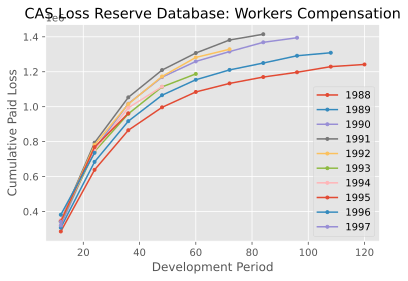

In [45]:
cl.load_sample('clrd').groupby('LOB').sum().loc['wkcomp', 'CumPaidLoss'].T.plot(
    marker='.',
    title='CAS Loss Reserve Database: Workers Compensation').set(
    xlabel='Development Period', ylabel='Cumulative Paid Loss');

Many of the more commonly used pandas methods are passed through in this way
allowing for working with triangles as DataFrames.


|Aggregations | IO               | Shaping     |  Other|
|-------------|------------------|-------------|---------------------|
|``sum``      | ``to_clipboard`` | ``unstack`` | ``plot``|
|``mean``     | ``to_csv``       | ``pivot``   | ``rename``|
|``median``   | ``to_excel``     | ``melt``    | ``pct_chg``|
|``max``      | ``to_json``      | ``T``       | ``round``|
|``min``      | ``to_html``      | ``drop``    | ``hvplot``|
|``prod``     | ``to_dict``      | ``dropna``  | ``drop_duplicates``|
|``var``      |                  |             | ``describe``|
|``std``      |                  |             |              |       
|``cumsum``   |                  |             |               |      
|``quantile`` |                  |             |                |      

```{note}
While some of these methods have been rewritten to return a Triangle, Many
are pandas methods and will have return values consistent with pandas.
```

### Accessors

Like pandas ``.str`` and ``.dt`` accessor functions, you can also perform operations
on the ``origin``, ``development`` or ``valuation`` of a triangle. For example, all
of these operations are legal.

In [46]:
raa = cl.load_sample('raa')
x = raa[raa.origin=='1986']
x = raa[(raa.development>=24)&(raa.development<=48)]
x = raa[raa.origin<='1985-JUN']
x = raa[raa.origin>'1987-01-01'][raa.development<=36]
x = raa[raa.valuation<raa.valuation_date]

These accessors apply boolean filtering along the ``origin`` or ``development`` of the
triangle.  Because boolean filtering can only work on one axis at a time, you may
need to split up your indexing to achieve a desired result.

```python
# Illegal use of boolean filtering of two different axes
x = raa[(raa.origin>'1987-01-01')&(raa.development<=36)]
# Instead, chain the boolean filters together.
x = raa[raa.origin>'1987-01-01'][raa.development<=36]
```   

When using the accessors to filter a triangle, you may be left with empty portions
of the triangle that need to be trimmed up.  The `dropna` method will look for
any origin periods or development periods that are fully empty at the edges
of the triangle and eliminate them for you.

In [47]:
raa = cl.load_sample('raa')
raa[raa.origin>'1987-01-01']

,12,24,36,48,60,72,84,96,108,120
1988,"1,351","6,947","13,112",,,,,,,
1989,"3,133","5,395",,,,,,,,
1990,"2,063",,,,,,,,,


There are many more methods available to manipulate triangles.  The complete
list of methods is available under the `Triangle` docstrings.
